## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')


<Figure size 432x288 with 0 Axes>

## Load and Normalize the data


In [2]:
glucose_series = sorted(
    [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
        for file in os.listdir(DATA_DIR)
        if file.startswith('Data')
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'batch_samples', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'batch_samples'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'calibration', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'calibration'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'standards_warm', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'standards_warm'
            )
        )
    ] + [
        glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, 'warm_standards_hamilton', file))
        for file in os.listdir(
            os.path.join(
                DATA_DIR,
                'warm_standards_hamilton'
            )
        )
    ],
    key=lambda one: one.real_concentration
)

selection = glucose_series

volt_mean = np.mean(np.concatenate([one.voltages for one in selection]))
volt_std = np.std(np.concatenate([one.voltages for one in selection]))
time_mean = np.mean(np.concatenate([one.points_in_time for one in selection]))
time_std = np.std(np.concatenate([one.points_in_time for one in selection]))

thinning_factor = 10

normed_series = [
    glucose_ts.data.GlucoseTS(
        voltages=(series.voltages - volt_mean) / volt_std,
        points_in_time=series.points_in_time,
        real_concentration=series.real_concentration,
    )    
    for series in selection
]

len(normed_series), set([one.real_concentration for one in selection])

(85,
 {0.0,
  0.05,
  0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.75,
  1,
  1.001,
  1.25,
  1.5,
  2.0,
  2.5,
  5.0,
  5.001,
  5.002,
  7.5,
  10.0})

# Using Rubanova et. alls method

## Creating Datasets

In [4]:
import random

validation_indices = random.sample(range(len(glucose_series)), k=15)

pure_training = [
    series 
    for idx, series in enumerate(glucose_series) 
    if not idx in validation_indices
]
pure_validation = [
    series 
    for idx, series in enumerate(glucose_series)
    if idx in validation_indices
]

print('We have %s training observations and %s validation series' % (len(pure_training), len(pure_validation)))

train_mean = np.mean([one.voltages for one in pure_training])
train_std = np.std([one.voltages for one in pure_training])

normalized_training = [
    glucose_ts.data.GlucoseTS(
        voltages=(one.voltages - train_mean) / train_std,
        points_in_time=one.points_in_time,
        real_concentration=one.real_concentration
    )
    for one in pure_training
]
normalized_validation = [
    glucose_ts.data.GlucoseTS(
        voltages=(one.voltages - train_mean) / train_std,
        points_in_time=one.points_in_time,
        real_concentration=one.real_concentration
    )
    for one in pure_validation
]

We have 70 training observations and 15 validation series


In [35]:
import math
import itertools

tf.keras.backend.set_floatx('float32')


ode_training = glucose_ts.data.tf_data_windows.time_and_volts_dataset(
    series=normalized_training,
    cluster_length=20,
    all_combinations=True,
)
ode_validation = glucose_ts.data.tf_data_windows.time_and_volts_dataset(
    series=normalized_validation,
    cluster_length=20,
    all_combinations=False,
)

num_units = 20

def train_ode_model(num_units, lstm_factor, regularization_strength):
    
    print(
        'num_units: %s \nlstm_factor: %4.2f \nreg_strength: %.2E' % (
            num_units, lstm_factor, regularization_strength))

    model = glucose_ts.models.bio_informed.RNNEncoderLatentODEDecoder(
        units=int(num_units * lstm_factor),
        total_length=50,
        label_length=40,
        rnn_regularization=regularization_strength,
        decoder_output_regularization=regularization_strength,
        ode_derivative_regularization=regularization_strength,
        dense_layer_sizes=[int(num_units / 2)] * 1 + [int(num_units / 4)] * 1,
        ode_layer_sizes=[int(num_units / 1)] * 2,
        prediction_sampling=5,
    )
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    )
    history = model.fit(
        ode_training.shuffle(100).batch(64).prefetch(tf.data.AUTOTUNE),
        validation_data=ode_validation.batch(64).prefetch(tf.data.AUTOTUNE),
        epochs=50,
        steps_per_epoch=100,
        callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            restore_best_weights=True
        )],
        use_multiprocessing=True,
    )
    # model.build((None, ))
    model.summary()
    
    return (model, history)

l2_reg_results = dict()

combinations = list(itertools.product([15, 20, 25], [0.5, 1.0, 1.5], [1e-7, 1e-6, 1e-5]))

print('number of combinations is %s' % len(combinations))

with tf.device("GPU:0"):


    for idx, parameter in enumerate(combinations):
        print('Number %s of %s' % (idx + 1, len(combinations)))
        l2_reg_results[parameter] = train_ode_model(*parameter)

    #     model, history = train_ode_model(20, 1., 1e-6)


number of combinations is 27
Number 1 of 27
num_units: 15 
lstm_factor: 0.50 
reg_strength: 1.00E-07
Epoch 1/50
100/100 [==============================] - 30s 236ms/step - loss: 0.4706 - val_loss: 0.0751
Epoch 2/50
100/100 [==============================] - 23s 228ms/step - loss: 0.1432 - val_loss: 0.0542
Epoch 3/50
100/100 [==============================] - 23s 228ms/step - loss: 0.0883 - val_loss: 0.0433
Epoch 4/50
100/100 [==============================] - 22s 224ms/step - loss: 0.0738 - val_loss: 0.0352
Epoch 5/50
100/100 [==============================] - 23s 226ms/step - loss: 0.0594 - val_loss: 0.0318
Epoch 6/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0565 - val_loss: 0.0491
Epoch 7/50
100/100 [==============================] - 23s 226ms/step - loss: 0.0518 - val_loss: 0.0295
Epoch 8/50
100/100 [==============================] - 22s 220ms/step - loss: 0.0489 - val_loss: 0.0297
Epoch 9/50
100/100 [==============================] - 22s 221ms/step - loss

Epoch 21/50
100/100 [==============================] - 20s 197ms/step - loss: 0.0469 - val_loss: 0.0180
Epoch 22/50
100/100 [==============================] - 20s 198ms/step - loss: 0.0478 - val_loss: 0.0211
Epoch 23/50
100/100 [==============================] - 20s 200ms/step - loss: 0.0432 - val_loss: 0.0208
Epoch 24/50
100/100 [==============================] - 20s 198ms/step - loss: 0.0435 - val_loss: 0.0184
Epoch 25/50
100/100 [==============================] - 20s 198ms/step - loss: 0.0422 - val_loss: 0.0184
Epoch 26/50
100/100 [==============================] - 20s 201ms/step - loss: 0.0387 - val_loss: 0.0168
Epoch 27/50
100/100 [==============================] - 20s 200ms/step - loss: 0.0395 - val_loss: 0.0230
Epoch 28/50
100/100 [==============================] - 20s 199ms/step - loss: 0.0379 - val_loss: 0.0154
Epoch 29/50
100/100 [==============================] - 20s 200ms/step - loss: 0.0371 - val_loss: 0.0155
Epoch 30/50
100/100 [==============================] - 20s 200ms

Epoch 42/50
100/100 [==============================] - 21s 211ms/step - loss: 0.0638 - val_loss: 0.0390
Epoch 43/50
100/100 [==============================] - 21s 209ms/step - loss: 0.0682 - val_loss: 0.0350
Epoch 44/50
100/100 [==============================] - 21s 211ms/step - loss: 0.0637 - val_loss: 0.0448
Epoch 45/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0596 - val_loss: 0.0375
Epoch 46/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0570 - val_loss: 0.0332
Epoch 47/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0543 - val_loss: 0.0336
Epoch 48/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0593 - val_loss: 0.0281
Epoch 49/50
100/100 [==============================] - 21s 215ms/step - loss: 0.0579 - val_loss: 0.0625
Epoch 50/50
100/100 [==============================] - 21s 208ms/step - loss: 0.0559 - val_loss: 0.0305
Model: "rnn_encoder_latent_ode_decoder_18"
_____________________

100/100 [==============================] - 21s 208ms/step - loss: 0.1194 - val_loss: 0.0559
Epoch 5/50
100/100 [==============================] - 21s 209ms/step - loss: 0.0980 - val_loss: 0.0455
Epoch 6/50
100/100 [==============================] - 20s 205ms/step - loss: 0.0855 - val_loss: 0.0417
Epoch 7/50
100/100 [==============================] - 21s 206ms/step - loss: 0.0782 - val_loss: 0.0393
Epoch 8/50
100/100 [==============================] - 21s 207ms/step - loss: 0.0740 - val_loss: 0.0401
Epoch 9/50
100/100 [==============================] - 21s 205ms/step - loss: 0.0713 - val_loss: 0.0496
Epoch 10/50
100/100 [==============================] - 20s 204ms/step - loss: 0.0705 - val_loss: 0.0380
Epoch 11/50
100/100 [==============================] - 21s 206ms/step - loss: 0.0661 - val_loss: 0.0354
Epoch 12/50
100/100 [==============================] - 20s 204ms/step - loss: 0.0650 - val_loss: 0.0376
Epoch 13/50
100/100 [==============================] - 21s 208ms/step - loss: 0.0

Epoch 25/50
100/100 [==============================] - 20s 201ms/step - loss: 0.0266 - val_loss: 0.0090
Epoch 26/50
100/100 [==============================] - 19s 195ms/step - loss: 0.0273 - val_loss: 0.0095
Epoch 27/50
100/100 [==============================] - 20s 196ms/step - loss: 0.0261 - val_loss: 0.0198
Epoch 28/50
100/100 [==============================] - 19s 195ms/step - loss: 0.0283 - val_loss: 0.0170
Epoch 29/50
100/100 [==============================] - 19s 194ms/step - loss: 0.0245 - val_loss: 0.0121
Epoch 30/50
100/100 [==============================] - 20s 197ms/step - loss: 0.0228 - val_loss: 0.0195
Epoch 31/50
100/100 [==============================] - 19s 195ms/step - loss: 0.0248 - val_loss: 0.0120
Epoch 32/50
100/100 [==============================] - 20s 195ms/step - loss: 0.0230 - val_loss: 0.0114
Epoch 33/50
100/100 [==============================] - 20s 196ms/step - loss: 0.0227 - val_loss: 0.0179
Epoch 34/50
100/100 [==============================] - 20s 196ms

100/100 [==============================] - 22s 225ms/step - loss: 0.0315 - val_loss: 0.0168
Epoch 17/50
100/100 [==============================] - 23s 225ms/step - loss: 0.0344 - val_loss: 0.0225
Epoch 18/50
100/100 [==============================] - 22s 225ms/step - loss: 0.0318 - val_loss: 0.0171
Epoch 19/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0312 - val_loss: 0.0185
Epoch 20/50
100/100 [==============================] - 22s 225ms/step - loss: 0.0336 - val_loss: 0.0168
Epoch 21/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0302 - val_loss: 0.0193
Epoch 22/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0341 - val_loss: 0.0167
Epoch 23/50
100/100 [==============================] - 22s 222ms/step - loss: 0.0370 - val_loss: 0.0208
Epoch 24/50
100/100 [==============================] - 21s 213ms/step - loss: 0.0293 - val_loss: 0.0362
Epoch 25/50
100/100 [==============================] - 22s 223ms/step - loss

Epoch 4/50
100/100 [==============================] - 21s 212ms/step - loss: 0.1630 - val_loss: 0.0516
Epoch 5/50
100/100 [==============================] - 21s 210ms/step - loss: 0.1184 - val_loss: 0.0434
Epoch 6/50
100/100 [==============================] - 21s 209ms/step - loss: 0.1066 - val_loss: 0.0377
Epoch 7/50
100/100 [==============================] - 21s 208ms/step - loss: 0.1040 - val_loss: 0.0438
Epoch 8/50
100/100 [==============================] - 21s 211ms/step - loss: 0.1003 - val_loss: 0.0372
Epoch 9/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0943 - val_loss: 0.0361
Epoch 10/50
100/100 [==============================] - 21s 210ms/step - loss: 0.0918 - val_loss: 0.0354
Epoch 11/50
100/100 [==============================] - 21s 212ms/step - loss: 0.0882 - val_loss: 0.0438
Epoch 12/50
100/100 [==============================] - 21s 214ms/step - loss: 0.0838 - val_loss: 0.0345
Epoch 13/50
100/100 [==============================] - 22s 217ms/step 

100/100 [==============================] - 20s 203ms/step - loss: 0.0365 - val_loss: 0.0303
Epoch 25/50
100/100 [==============================] - 20s 203ms/step - loss: 0.0354 - val_loss: 0.0159
Epoch 26/50
100/100 [==============================] - 20s 201ms/step - loss: 0.0387 - val_loss: 0.0160
Epoch 27/50
100/100 [==============================] - 21s 206ms/step - loss: 0.0343 - val_loss: 0.0146
Epoch 28/50
100/100 [==============================] - 20s 204ms/step - loss: 0.0401 - val_loss: 0.0167
Epoch 29/50
100/100 [==============================] - 20s 199ms/step - loss: 0.0366 - val_loss: 0.0341
Epoch 30/50
100/100 [==============================] - 20s 197ms/step - loss: 0.0377 - val_loss: 0.0180
Epoch 31/50
100/100 [==============================] - 20s 204ms/step - loss: 0.0334 - val_loss: 0.0202
Epoch 32/50
100/100 [==============================] - 20s 202ms/step - loss: 0.0360 - val_loss: 0.0247
Epoch 33/50
100/100 [==============================] - 20s 200ms/step - loss

Epoch 45/50
100/100 [==============================] - 22s 222ms/step - loss: 0.0375 - val_loss: 0.0192
Epoch 46/50
100/100 [==============================] - 22s 219ms/step - loss: 0.0405 - val_loss: 0.0228
Epoch 47/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0378 - val_loss: 0.0202
Epoch 48/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0383 - val_loss: 0.0234
Epoch 49/50
100/100 [==============================] - 22s 219ms/step - loss: 0.0364 - val_loss: 0.0184
Epoch 50/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0354 - val_loss: 0.0199
Model: "rnn_encoder_latent_ode_decoder_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_27 (GRU)                 multiple                  390       
_________________________________________________________________
sequential_54 (Sequential)   (None, 10)                850       
___

100/100 [==============================] - 21s 205ms/step - loss: 0.0236 - val_loss: 0.0125
Epoch 27/50
100/100 [==============================] - 21s 208ms/step - loss: 0.0228 - val_loss: 0.0250
Epoch 28/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0217 - val_loss: 0.0128
Epoch 29/50
100/100 [==============================] - 20s 199ms/step - loss: 0.0252 - val_loss: 0.0210
Epoch 30/50
100/100 [==============================] - 20s 203ms/step - loss: 0.0241 - val_loss: 0.0112
Epoch 31/50
100/100 [==============================] - 20s 203ms/step - loss: 0.0228 - val_loss: 0.0137
Model: "rnn_encoder_latent_ode_decoder_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 multiple                  1380      
_________________________________________________________________
sequential_58 (Sequential)   (None, 20)                1260      
_______________

Epoch 20/50
100/100 [==============================] - 24s 240ms/step - loss: 0.0466 - val_loss: 0.0486
Epoch 21/50
100/100 [==============================] - 24s 235ms/step - loss: 0.0435 - val_loss: 0.0243
Epoch 22/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0422 - val_loss: 0.0374
Epoch 23/50
100/100 [==============================] - 23s 230ms/step - loss: 0.0398 - val_loss: 0.0194
Epoch 24/50
100/100 [==============================] - 24s 237ms/step - loss: 0.0362 - val_loss: 0.0174
Epoch 25/50
100/100 [==============================] - 24s 234ms/step - loss: 0.0363 - val_loss: 0.0194
Epoch 26/50
100/100 [==============================] - 23s 232ms/step - loss: 0.0367 - val_loss: 0.0159
Epoch 27/50
100/100 [==============================] - 24s 237ms/step - loss: 0.0328 - val_loss: 0.0206
Epoch 28/50
100/100 [==============================] - 23s 229ms/step - loss: 0.0361 - val_loss: 0.0198
Epoch 29/50
100/100 [==============================] - 23s 233ms

100/100 [==============================] - 23s 231ms/step - loss: 0.0344 - val_loss: 0.0169
Epoch 13/50
100/100 [==============================] - 22s 225ms/step - loss: 0.0373 - val_loss: 0.0145
Epoch 14/50
100/100 [==============================] - 23s 226ms/step - loss: 0.0310 - val_loss: 0.0134
Epoch 15/50
100/100 [==============================] - 22s 225ms/step - loss: 0.0304 - val_loss: 0.0134
Epoch 16/50
100/100 [==============================] - 23s 226ms/step - loss: 0.0292 - val_loss: 0.0135
Epoch 17/50
100/100 [==============================] - 22s 222ms/step - loss: 0.0272 - val_loss: 0.0131
Epoch 18/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0283 - val_loss: 0.0156
Epoch 19/50
100/100 [==============================] - 22s 221ms/step - loss: 0.0279 - val_loss: 0.0320
Epoch 20/50
100/100 [==============================] - 22s 220ms/step - loss: 0.0289 - val_loss: 0.0141
Epoch 21/50
100/100 [==============================] - 22s 222ms/step - loss

Epoch 40/50
100/100 [==============================] - 24s 236ms/step - loss: 0.0252 - val_loss: 0.0136
Model: "rnn_encoder_latent_ode_decoder_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 multiple                  540       
_________________________________________________________________
sequential_68 (Sequential)   (None, 12)                1287      
_________________________________________________________________
sequential_69 (Sequential)   (None, 1)                 241       
Total params: 2,068
Trainable params: 2,068
Non-trainable params: 0
_________________________________________________________________
Number 20 of 27
num_units: 25 
lstm_factor: 0.50 
reg_strength: 1.00E-06
Epoch 1/50
100/100 [==============================] - 32s 255ms/step - loss: 0.8806 - val_loss: 0.1041
Epoch 2/50
100/100 [==============================] - 23s 231ms/step - loss: 0.21

100/100 [==============================] - 21s 208ms/step - loss: 0.0258 - val_loss: 0.0310
Epoch 28/50
100/100 [==============================] - 21s 209ms/step - loss: 0.0281 - val_loss: 0.0279
Epoch 29/50
100/100 [==============================] - 21s 206ms/step - loss: 0.0296 - val_loss: 0.0210
Epoch 30/50
100/100 [==============================] - 21s 208ms/step - loss: 0.0258 - val_loss: 0.0273
Epoch 31/50
100/100 [==============================] - 21s 207ms/step - loss: 0.0248 - val_loss: 0.0149
Epoch 32/50
100/100 [==============================] - 21s 207ms/step - loss: 0.0271 - val_loss: 0.0175
Epoch 33/50
100/100 [==============================] - 21s 210ms/step - loss: 0.0254 - val_loss: 0.0194
Model: "rnn_encoder_latent_ode_decoder_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 multiple                  540       
___________________________________________

Epoch 9/50
100/100 [==============================] - 24s 240ms/step - loss: 0.0428 - val_loss: 0.0329
Epoch 10/50
100/100 [==============================] - 24s 239ms/step - loss: 0.0370 - val_loss: 0.0241
Epoch 11/50
100/100 [==============================] - 24s 236ms/step - loss: 0.0379 - val_loss: 0.0156
Epoch 12/50
100/100 [==============================] - 24s 240ms/step - loss: 0.0345 - val_loss: 0.0130
Epoch 13/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0333 - val_loss: 0.0254
Epoch 14/50
100/100 [==============================] - 24s 240ms/step - loss: 0.0343 - val_loss: 0.0196
Epoch 15/50
100/100 [==============================] - 24s 242ms/step - loss: 0.0304 - val_loss: 0.0140
Epoch 16/50
100/100 [==============================] - 24s 239ms/step - loss: 0.0294 - val_loss: 0.0147
Epoch 17/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0282 - val_loss: 0.0116
Epoch 18/50
100/100 [==============================] - 24s 239ms/

100/100 [==============================] - 33s 272ms/step - loss: 0.5494 - val_loss: 0.0642
Epoch 2/50
100/100 [==============================] - 38s 375ms/step - loss: 0.1192 - val_loss: 0.0376
Epoch 3/50
100/100 [==============================] - 23s 227ms/step - loss: 0.0718 - val_loss: 0.0308
Epoch 4/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0585 - val_loss: 0.0226
Epoch 5/50
100/100 [==============================] - 26s 258ms/step - loss: 0.0534 - val_loss: 0.0218
Epoch 6/50
100/100 [==============================] - 25s 254ms/step - loss: 0.0469 - val_loss: 0.0227
Epoch 7/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0426 - val_loss: 0.0225
Epoch 8/50
100/100 [==============================] - 24s 244ms/step - loss: 0.0418 - val_loss: 0.0243
Epoch 9/50
100/100 [==============================] - 25s 246ms/step - loss: 0.0375 - val_loss: 0.0249
Epoch 10/50
100/100 [==============================] - 26s 256ms/step - loss: 0.0393

Epoch 22/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0362 - val_loss: 0.0264
Epoch 23/50
100/100 [==============================] - 26s 257ms/step - loss: 0.0370 - val_loss: 0.0217
Epoch 24/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0388 - val_loss: 0.0180
Epoch 25/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0339 - val_loss: 0.0169
Epoch 26/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0359 - val_loss: 0.0237
Epoch 27/50
100/100 [==============================] - 26s 256ms/step - loss: 0.0366 - val_loss: 0.0199
Epoch 28/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0317 - val_loss: 0.0199
Epoch 29/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0341 - val_loss: 0.0158
Epoch 30/50
100/100 [==============================] - 25s 253ms/step - loss: 0.0352 - val_loss: 0.0186
Epoch 31/50
100/100 [==============================] - 51s 513ms

100/100 [==============================] - 24s 237ms/step - loss: 0.0241 - val_loss: 0.0140
Epoch 43/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0212 - val_loss: 0.0140
Epoch 44/50
100/100 [==============================] - 24s 236ms/step - loss: 0.0216 - val_loss: 0.0125
Epoch 45/50
100/100 [==============================] - 24s 239ms/step - loss: 0.0191 - val_loss: 0.0220
Epoch 46/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0210 - val_loss: 0.0212
Epoch 47/50
100/100 [==============================] - 23s 233ms/step - loss: 0.0229 - val_loss: 0.0153
Epoch 48/50
100/100 [==============================] - 24s 241ms/step - loss: 0.0187 - val_loss: 0.0153
Epoch 49/50
100/100 [==============================] - 23s 233ms/step - loss: 0.0200 - val_loss: 0.0132
Epoch 50/50
100/100 [==============================] - 24s 237ms/step - loss: 0.0161 - val_loss: 0.0152
Model: "rnn_encoder_latent_ode_decoder_42"
_________________________________

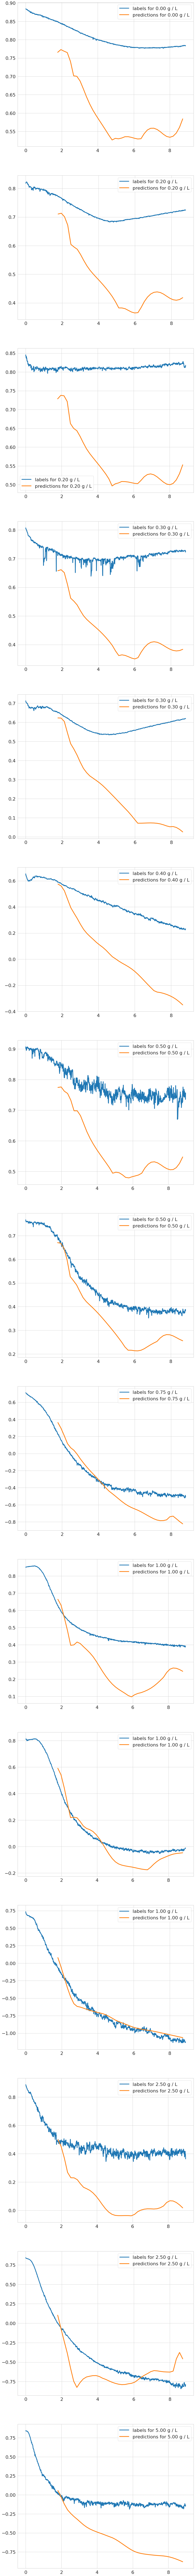

In [37]:
model = l2_reg_results[(25, 1.5, 1e-7)][0]
# Plot the results
def plot_ode_model(series, model, cut_off, voltage_sampling):
    
    
    fig, axises = plt.subplots(len(series), 1, figsize=(15, len(series) * 15))
    
    for one_series, ax in zip(series, axises):

        ax.plot(
            one_series.points_in_time,
            one_series.voltages,
            label='labels for %4.2f g / L' % one_series.real_concentration,
        )
        ax.plot(
            one_series.points_in_time[cut_off + voltage_sampling + 1::voltage_sampling],
            model(
                (
                    one_series.points_in_time[np.newaxis, cut_off::voltage_sampling],
                    one_series.voltages[np.newaxis, :cut_off:voltage_sampling]
                )
            )[0, :],
            label='predictions for %4.2f g / L' % one_series.real_concentration,
        )
        ax.legend()

        
plot_ode_model(normalized_validation, model, cut_off=180, voltage_sampling=20)


In [43]:
one_series.voltages[np.newaxis, :400:20].shape

(1, 20)